Andrea Hanel 2024

# Figure 3

- HVG using Laplacian score (LS) - selected features from Delve benchmark
- PCA
- Harmony-corrected PCs
- UMAP
- adding cell type annotation from Zhang 2024 (cellHarmony/AltAnalyze result)
- Leiden clustering
- FDG (FA layout)
- Diffusion map

In [1]:
import scanpy as sc
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

!echo "Conda Environment: $CONDA_DEFAULT_ENV"
from datetime import datetime
print(f"Date: {datetime.now():%Y-%m-%d}")

Conda Environment: tired_like_a_kitten
Date: 2024-11-27


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                         10.3.0
anyio                       NA
argcomplete                 NA
arrow                       1.3.0
asttokens                   NA
attr                        24.2.0
attrs                       24.2.0
babel                       2.16.0
brotli                      1.1.0
certifi                     2024.08.30
cffi                        1.16.0
charset_normalizer          3.3.2
colorama                    0.4.6
comm                        0.2.2
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0.post0
debugpy                     1.8.5
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.2.2
executing                   2.1.0
fastjsonschema              NA
fqdn                        NA
gmpy2                       2.1.5
google                      NA
h5py                        3.11.0
idna                        3.7
igr

In [3]:
adata = sc.read_h5ad ("/research/groups/sysgen/PROJECTS/sysgen_team/andrea_work/2023_Fischer_iPSC/revision_final/data/adata2_norm.h5ad")


In [4]:
adata

AnnData object with n_obs × n_vars = 32358 × 33233
    obs: 'sample', 'etv6_runx1', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'celline'
    var: 'gene_id', '2', 'n_cells'
    uns: 'sample_colors'
    layers: 'log1p_norm', 'raw_counts'

In [5]:
adata.X = adata.layers["log1p_norm"]

## HVG alternative

In [11]:
LS = pd.read_csv("/research/groups/sysgen/PROJECTS/sysgen_team/andrea_work/delve_benchmark/outs/RPE/predicted_features/laplacian_score_fs.csv"
)

In [12]:
LS.head()

Unnamed: 0  laplacian_score
0       PPBP         0.110402
1      GNG11         0.117303
2      RPS16         0.120914
3     ITGA2B         0.123351
4       CNST         0.126515

In [13]:
hvg_genes = LS["Unnamed: 0"].values
adata.var["highly_variable"] = adata.var_names.isin(hvg_genes)

### Non-scaled PCA

> scaling not in Theis recomm https://www.sc-best-practices.org/preprocessing_visualization/dimensionality_reduction.html
>
> https://github.com/theislab/single-cell-best-practices/issues/185

In [14]:
sc.tl.pca(adata, n_comps=50)

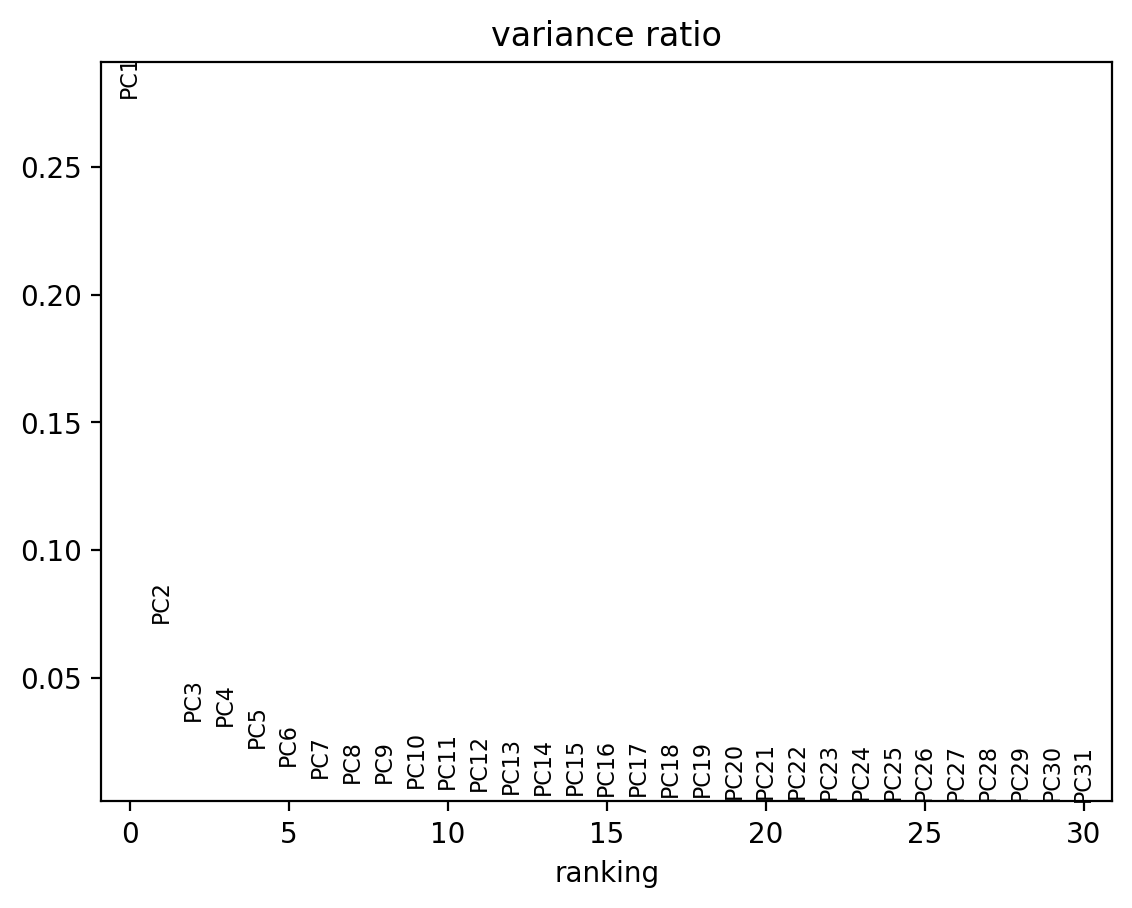

In [15]:
sc.pl.pca_variance_ratio(adata, log=False)

In [16]:
adata

AnnData object with n_obs × n_vars = 32358 × 33233
    obs: 'sample', 'etv6_runx1', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'celline'
    var: 'gene_id', '2', 'n_cells', 'highly_variable'
    uns: 'sample_colors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'log1p_norm', 'raw_counts'

In [17]:
pca = adata.obsm['X_pca']
batch = adata.obs['celline']

In [18]:
# load up harmony in rpy2
%load_ext rpy2.ipython

In [19]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

#batch <- as.factor(batch)

hem = HarmonyMatrix(pca, batch, theta=2, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

Loading required package: Rcpp
Transposing data matrix
Initializing state using k-means centroids initialization
Harmony 1/10
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 2/10
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 3/10
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
0%   10   20   30   40   50   60   70   80   90   100

In [20]:
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

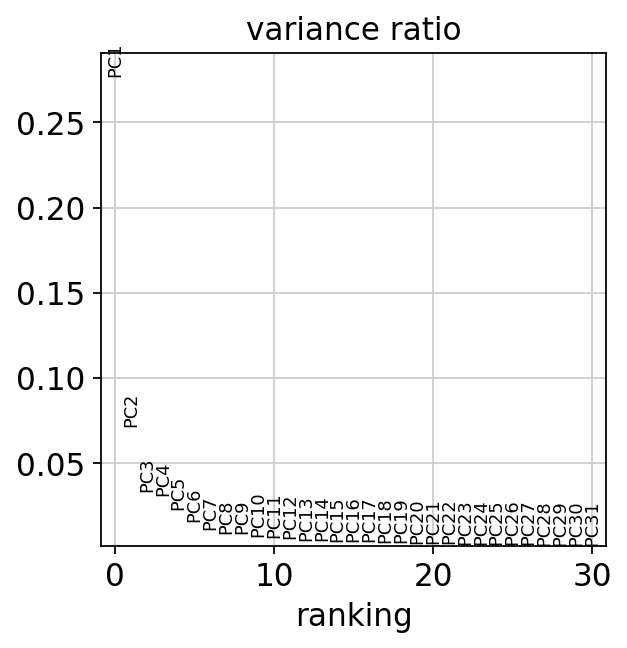

In [21]:
sc.set_figure_params(figsize=(4, 4))
sc.pl.pca_variance_ratio(adata, log=False)

In [22]:
adata

AnnData object with n_obs × n_vars = 32358 × 33233
    obs: 'sample', 'etv6_runx1', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'celline'
    var: 'gene_id', '2', 'n_cells', 'highly_variable'
    uns: 'sample_colors', 'pca'
    obsm: 'X_pca', 'X_orig_pca'
    varm: 'PCs'
    layers: 'log1p_norm', 'raw_counts'

In [23]:
sc.pp.neighbors(adata, 
                n_neighbors=30, n_pcs=50, use_rep=None, knn=True, random_state=0, method='umap', metric='euclidean', 
                 key_added=None, copy=False)

In [24]:
sc.tl.umap(adata, 
               min_dist=0.5, spread=1.0, n_components=2, maxiter=None, 
               alpha=1.0, gamma=1.0, negative_sample_rate=5, init_pos='spectral', 
               random_state=0, a=None, b=None, copy=False, method='umap', neighbors_key=None)


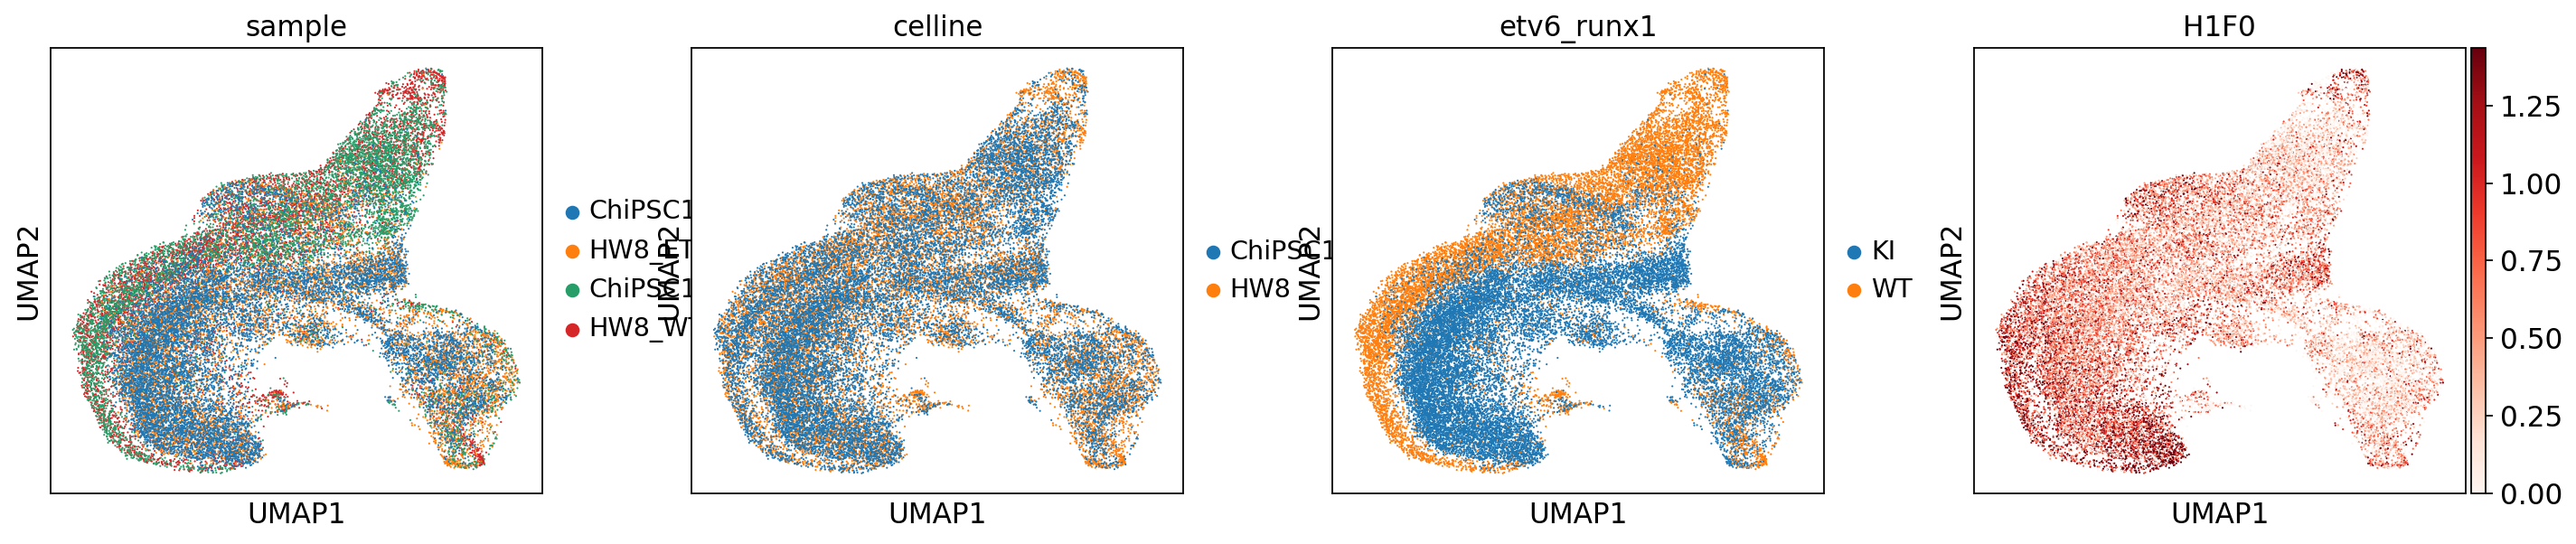

In [25]:
plt.rcParams['figure.figsize']=(4.5,4)
plt.rcParams['savefig.dpi'] = 1200

list_to_plot = ["sample", "celline", "etv6_runx1", "H1F0"]


sc.pl.umap(
         adata, 
    cmap = "Reds",
          color= list_to_plot,
    layer = "log1p_norm",
         vmin = 0, 
         vmax="p95",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=True,
)

In [26]:
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)

/tmp/ipykernel_1109584/3247590075.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)


In [27]:
adata

AnnData object with n_obs × n_vars = 32358 × 33233
    obs: 'sample', 'etv6_runx1', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'celline', 'leiden_res0_25'
    var: 'gene_id', '2', 'n_cells', 'highly_variable'
    uns: 'sample_colors', 'pca', 'neighbors', 'umap', 'celline_colors', 'etv6_runx1_colors', 'leiden_res0_25'
    obsm: 'X_pca', 'X_orig_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p_norm', 'raw_counts'
    obsp: 'distances', 'connectivities'

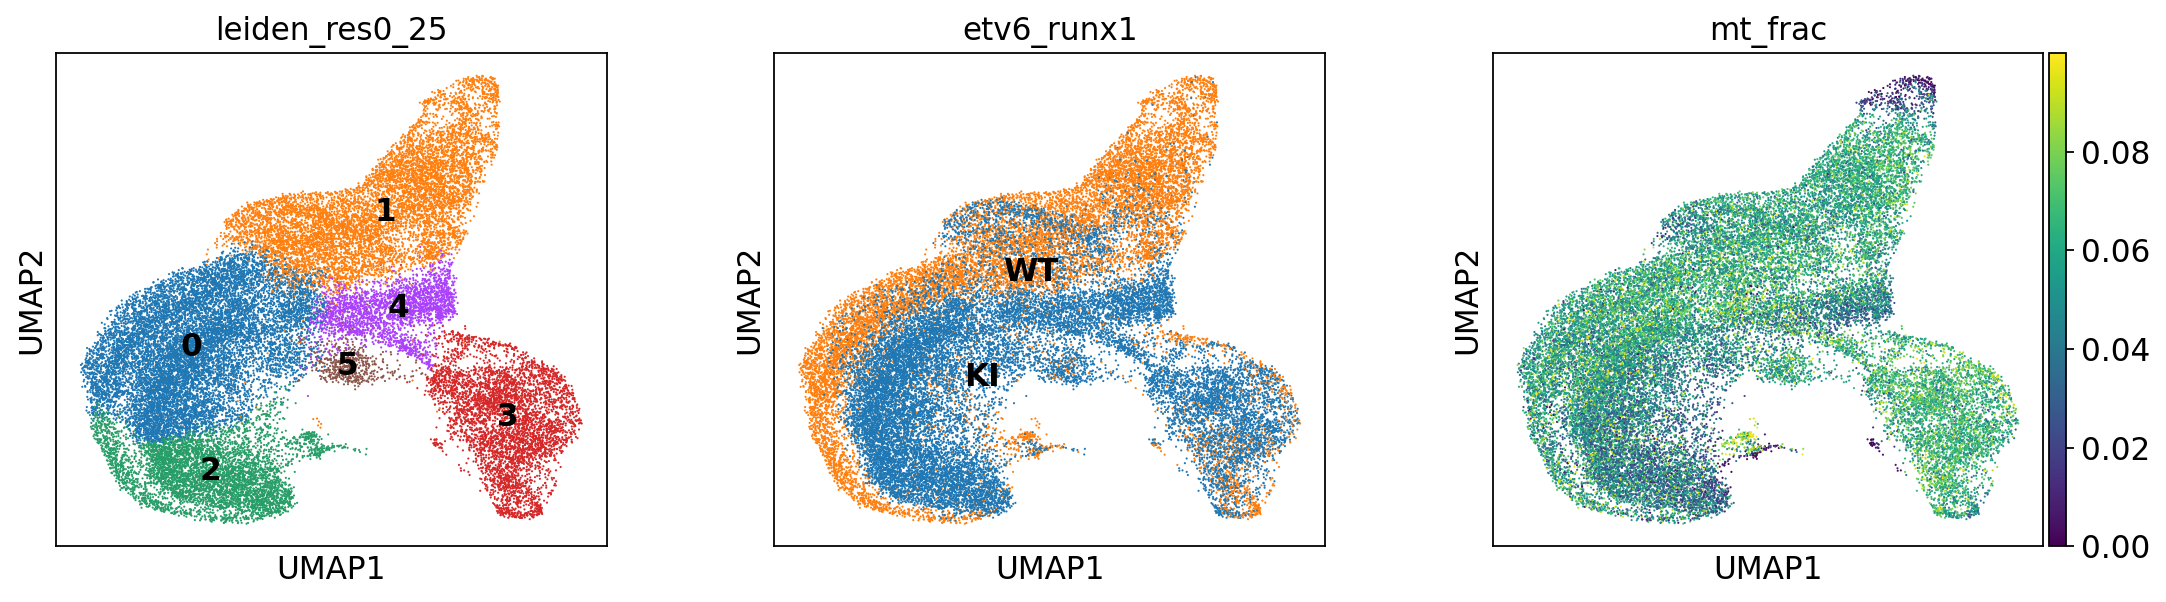

In [28]:
plt.rcParams['figure.figsize']=(4.5,4)
plt.rcParams['savefig.dpi'] = 1200

list_to_plot = ["leiden_res0_25","etv6_runx1", "mt_frac"]


sc.pl.umap(
         adata, 
   # cmap = "Reds",
          color= list_to_plot,
    legend_loc="on data",
    layer = "log1p_norm",
         vmin = 0, 
        # vmax="p95",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=True,
)

In [29]:
cell_cycle_genes = [x.strip() for x in open('../data/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

s_genes_mm = adata.var_names[np.isin(adata.var_names, s_genes)]
g2m_genes_mm = adata.var_names[np.isin(adata.var_names, g2m_genes)]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_mm, g2m_genes=g2m_genes_mm)

adata.obs["phase_combined"] = adata.obs["phase"].replace(["G2M", "S"], ["G2M/S", "G2M/S"])
adata.obs["S/G2M_score_combined"] = (adata.obs["G2M_score"] + adata.obs["S_score"])/2


97
94


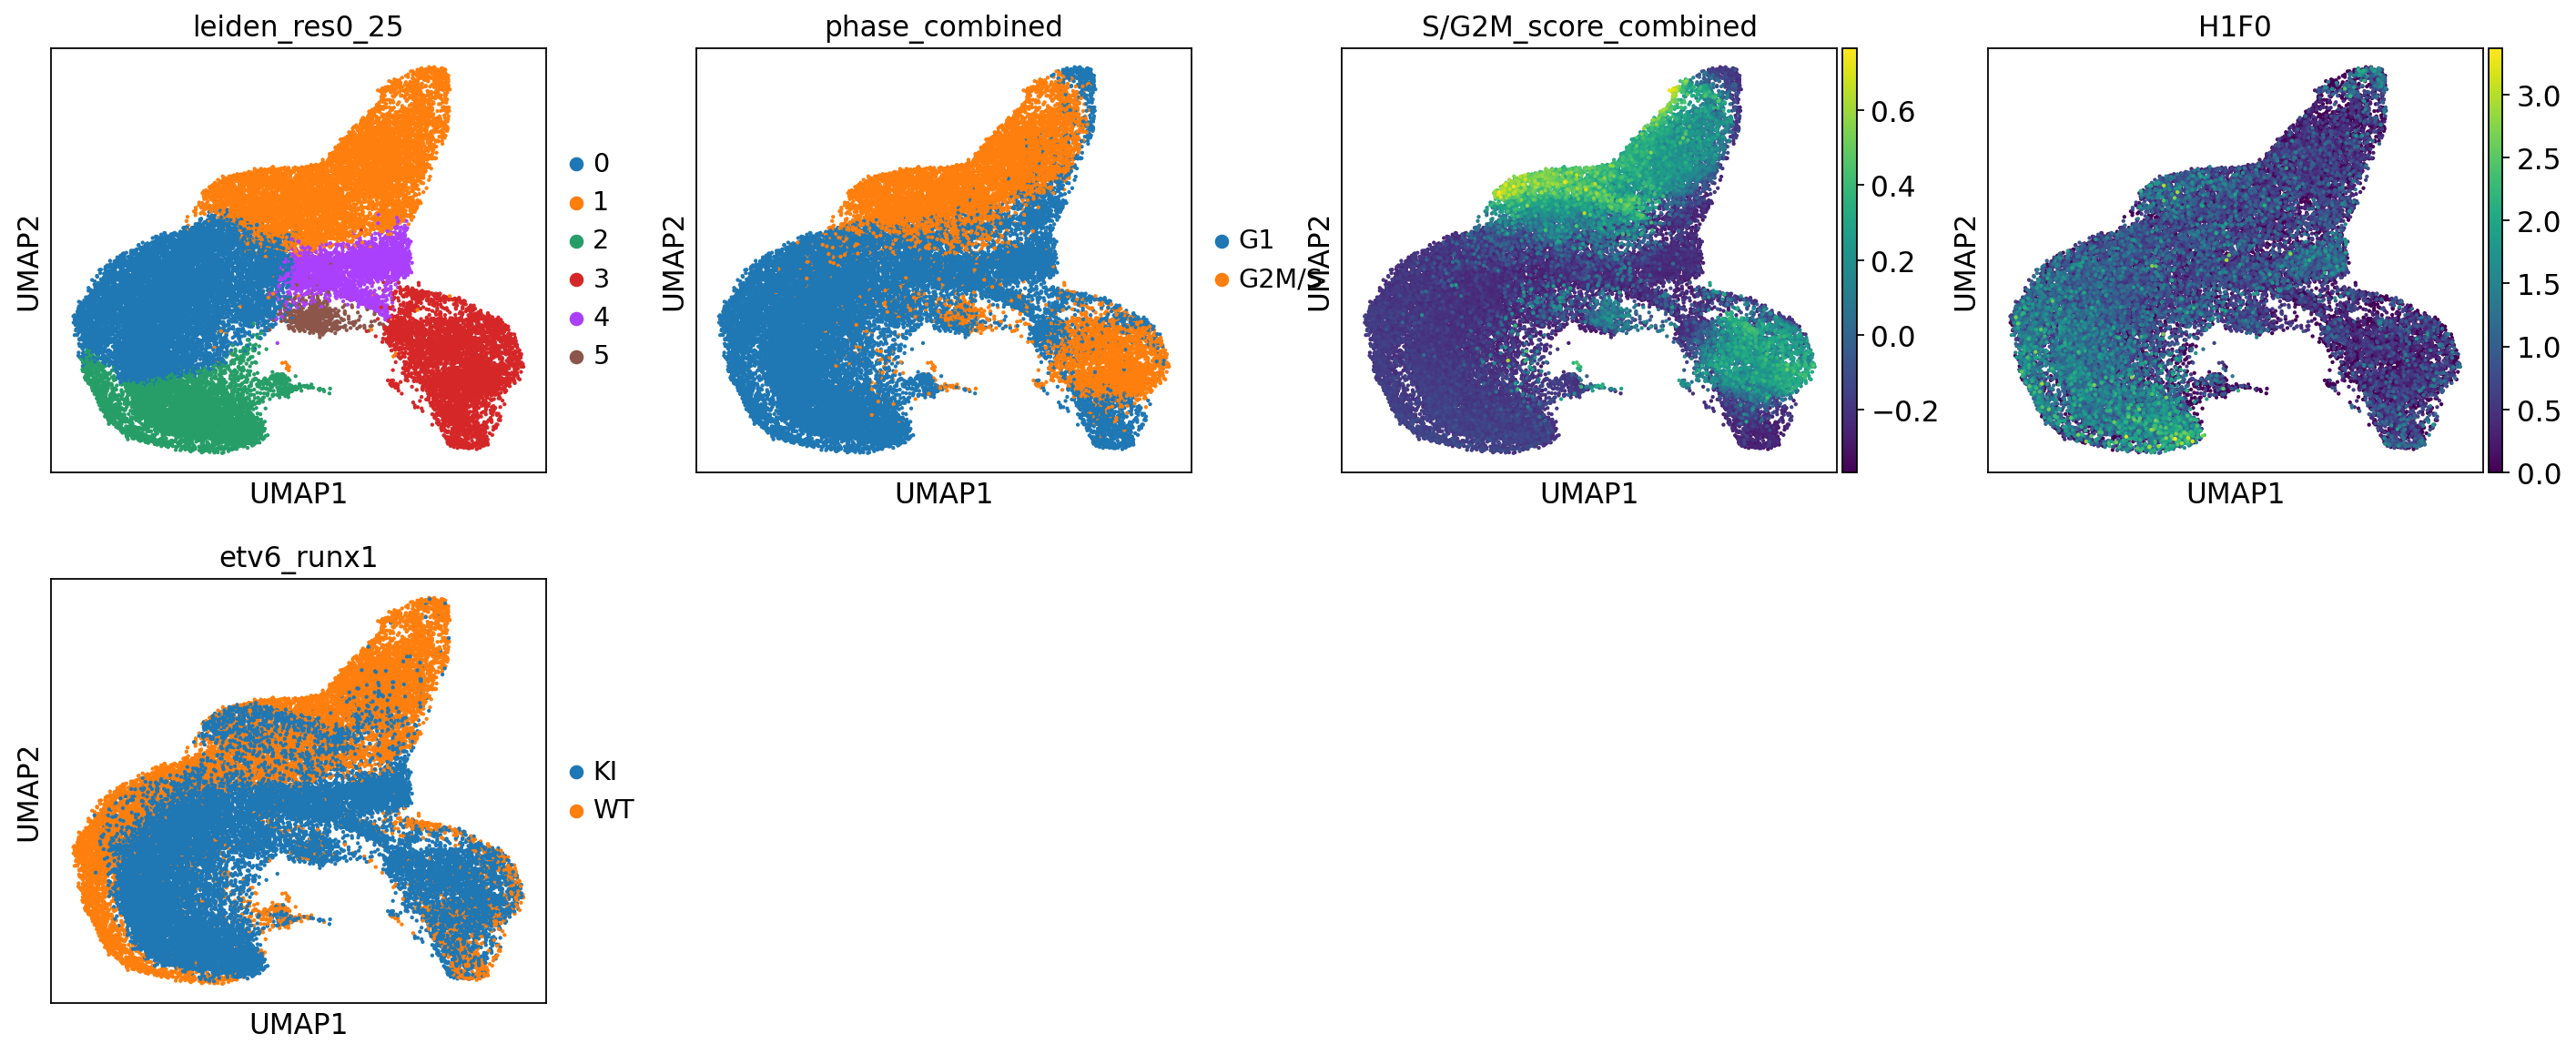

In [30]:
sc.pl.umap(adata, color=['leiden_res0_25', 'phase_combined',"S/G2M_score_combined", "H1F0", "etv6_runx1"], size=15) 

In [31]:
adata_zhang = sc.read_h5ad (
 "/research/groups/sysgen/PROJECTS/sysgen_team/andrea_work/2023_Fischer_iPSC/revision_final/data/adata2_merged_sctriangl.h5ad"   
)

In [32]:
adata_zhang.obs['Level 2']

AAACCCAAGCGAACTG-1         Erythroid
AAACCCACAAGAGTTA-1    Megakaryocytic
AAACCCACAAGCTCTA-1    Megakaryocytic
AAACCCAGTAGGAGGG-1    Megakaryocytic
AAACCCATCTGTCTCG-1    Megakaryocytic
                           ...      
TTTGTTGGTTCCAAAC-4         Erythroid
TTTGTTGTCCCAAGTA-4    Megakaryocytic
TTTGTTGTCCGGCAGT-4    Megakaryocytic
TTTGTTGTCCGTATAG-4    Megakaryocytic
TTTGTTGTCGTAGGAG-4    Megakaryocytic
Name: Level 2, Length: 32358, dtype: category
Categories (10, object): ['B cell', 'Ba/Ma/Eo', 'Dendritic', 'Early-lymphoid', ..., 'HSPC', 'Megakaryocytic', 'Monocytic', 'Stroma']

In [33]:
adata.obs['Level 1'] = adata_zhang.obs['Level 1']
adata.obs['Level 2'] = adata_zhang.obs['Level 2']
adata.obs['Max-Rho'] = adata_zhang.obs['Max-Rho']
adata.obs["Combined Correlation DiffScore"] = adata_zhang.obs["Combined Correlation DiffScore"]


In [34]:
color_mapping = {
    "HSC": "#F4C3D5",
    "MPP": "#EA7298",
    "MultiLin": "#F79BA3",
    "MEP": "#FEAE99",
    "early-Erythroid": "#ef394c",
    "late-Erythroid": "#B60C2B",
    "MKP": "#E2D7D0",
    "CLP": "#BCFDFE",
    "Transitional-B": "#72F6FB",
    "pre-B": "#63D8DA",
    "B cell": "#4890B2",
    "Plasma Cell": "#041247",
    "CD4 T-cell": "#AF98C6",
    "T/NK": "#441C46",
    "GMP": "#EED2C9",
    "early-Neu": "#D2C6AB",
    "early-Mono": "#F0A657",
    "Monocyte": "#974000",
    "Myeloid intermediate": "#D28850",
    "MDP": "#D4AD85",
    "pre-DC": "#FFDCC4",
    "cDC": "#DC906A",
    "pDC": "#DE6A67",
    "ASDC": "#B06050",
     'Ba/Ma/Eo': "purple",
    "Mac":"black",
    "Stroma":"brown"
}

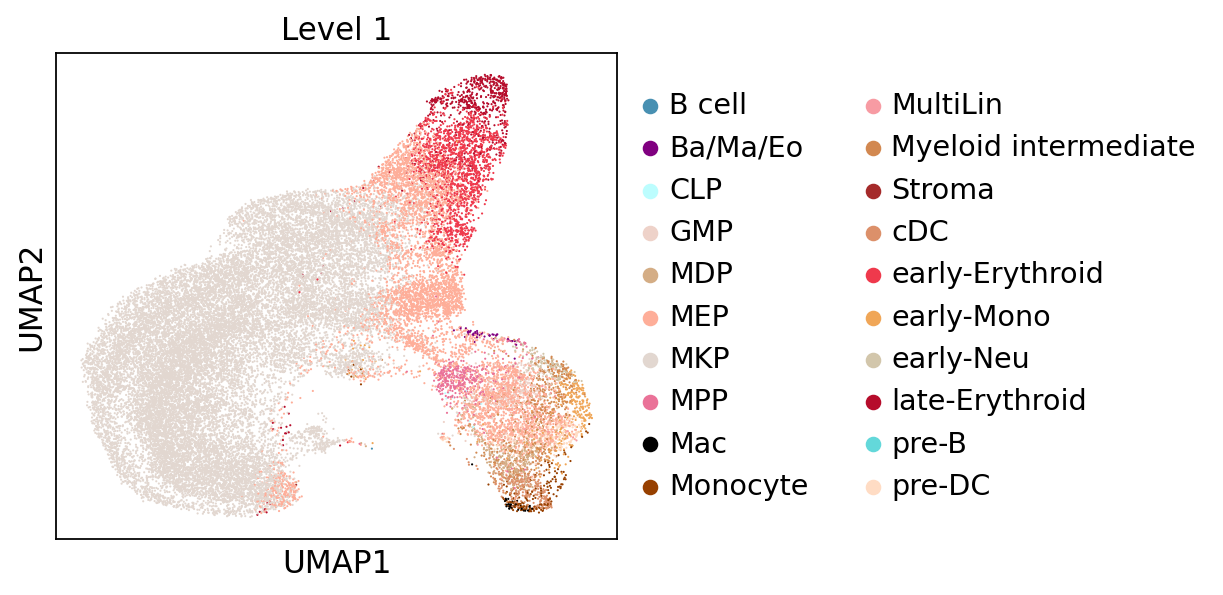

In [35]:
# Apply to UMAP
sc.pl.umap(
    adata,
    color= ["Level 1"],
    palette=color_mapping,  # Use custom palette
    layer="log1p_norm",
    vmin=0,
    sort_order=False,
    frameon=True
)


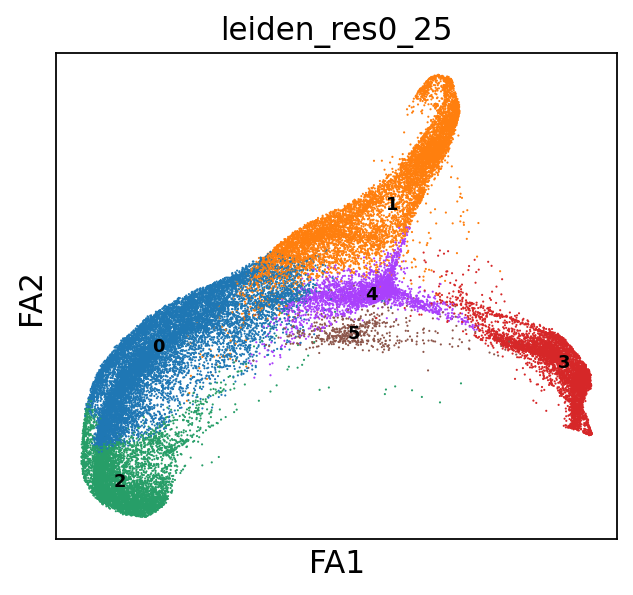

In [36]:
# use the umap to initialize the graph layout.
sc.tl.draw_graph(adata, init_pos='X_umap')
sc.pl.draw_graph(adata, color='leiden_res0_25', 
                 legend_loc='on data', legend_fontsize = 'xx-small')

In [38]:
adata.X = adata.layers["raw_counts"]

In [39]:
adata.write ("/research/groups/sysgen/PROJECTS/sysgen_team/andrea_work/2023_Fischer_iPSC/revision_final/data/adata2_PCAharmony_leiden_LS.h5ad")
 

## Calculate Diffusion Map

In [1]:
import scanpy as sc
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'



!echo "Conda Environment: $CONDA_DEFAULT_ENV"
from datetime import datetime
print(f"Date: {datetime.now():%Y-%m-%d}")

Conda Environment: tired_like_a_kitten
Date: 2024-12-06


In [2]:
adata = sc.read_h5ad ("/research/groups/sysgen/PROJECTS/sysgen_team/andrea_work/2023_Fischer_iPSC/revision_final/data/adata2_PCAharmony_leiden_LS.h5ad")
                      

In [3]:
adata

AnnData object with n_obs × n_vars = 32358 × 33233
    obs: 'sample', 'etv6_runx1', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'celline', 'leiden_res0_25', 'S_score', 'G2M_score', 'phase', 'phase_combined', 'S/G2M_score_combined', 'Level 1', 'Level 2', 'Max-Rho', 'Combined Correlation DiffScore'
    var: 'gene_id', '2', 'n_cells', 'highly_variable'
    uns: 'Level 1_colors', 'celline_colors', 'draw_graph', 'etv6_runx1_colors', 'leiden_res0_25', 'leiden_res0_25_colors', 'neighbors', 'pca', 'phase_combined_colors', 'sample_colors', 'umap'
    obsm: 'X_draw_graph_fa', 'X_orig_pca', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [5]:
sc.tl.diffmap(adata, n_comps=15, #neighbors_key=neighbors, 
              random_state=0)


In [6]:
adata

AnnData object with n_obs × n_vars = 32358 × 33233
    obs: 'sample', 'etv6_runx1', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'celline', 'leiden_res0_25', 'S_score', 'G2M_score', 'phase', 'phase_combined', 'S/G2M_score_combined', 'Level 1', 'Level 2', 'Max-Rho', 'Combined Correlation DiffScore'
    var: 'gene_id', '2', 'n_cells', 'highly_variable'
    uns: 'Level 1_colors', 'celline_colors', 'draw_graph', 'etv6_runx1_colors', 'leiden_res0_25', 'leiden_res0_25_colors', 'neighbors', 'pca', 'phase_combined_colors', 'sample_colors', 'umap', 'diffmap_evals'
    obsm: 'X_draw_graph_fa', 'X_orig_pca', 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    layers: 'log1p_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

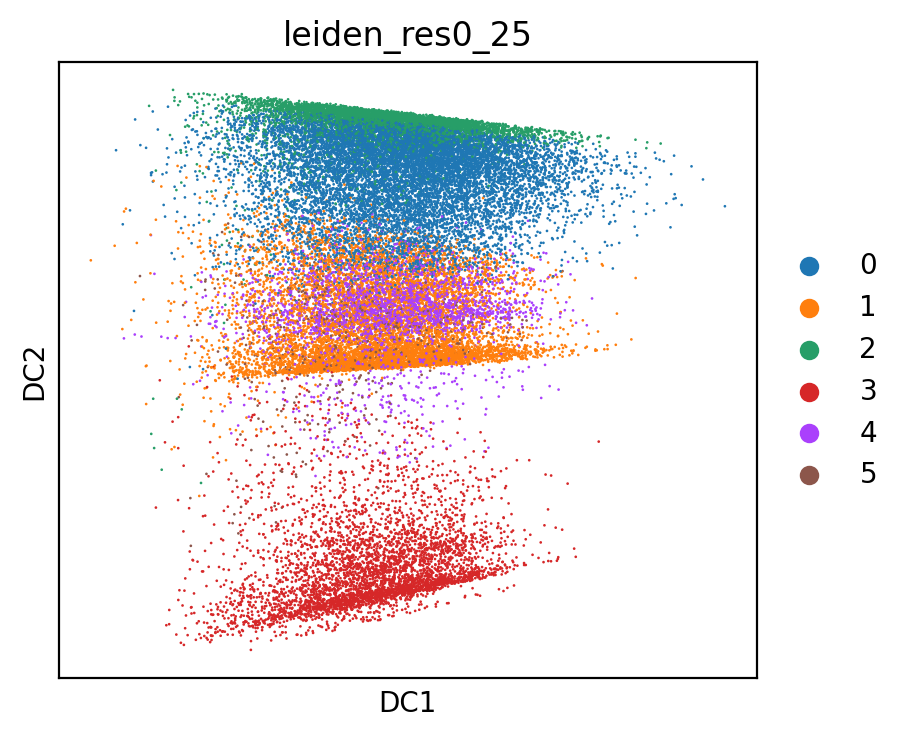

In [8]:
plt.rcParams['figure.figsize']=(4.5,4)
plt.rcParams['savefig.dpi'] = 1200
sc.pl.diffmap(adata, color='leiden_res0_25')

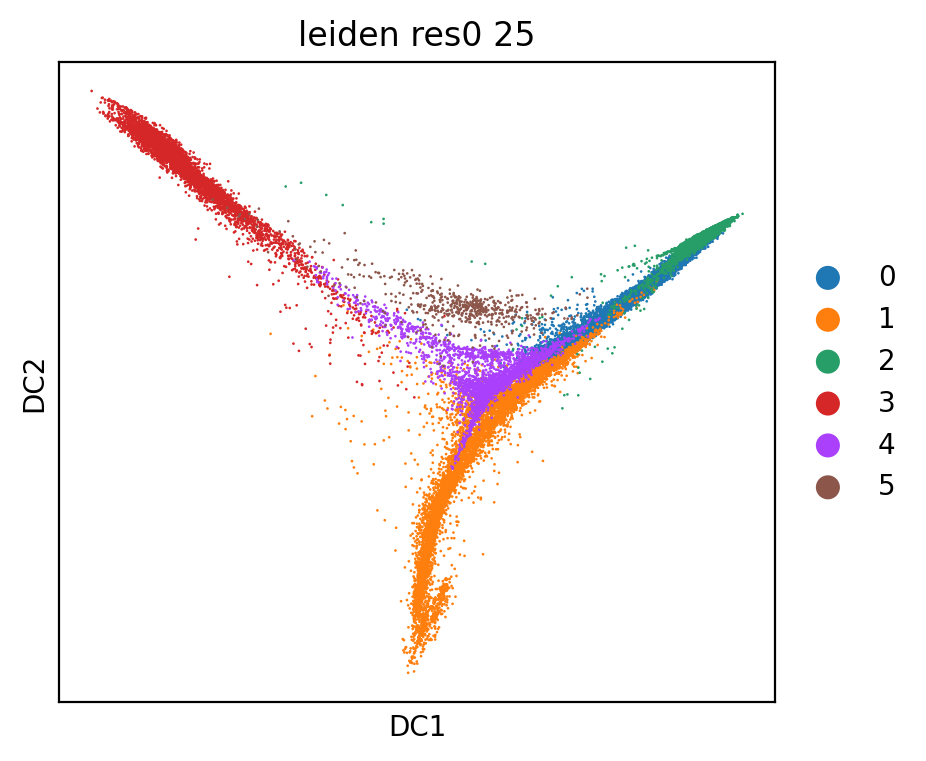

In [11]:
# Setting root cell as described above (from Theis lab best practices tutorial: https://www.sc-best-practices.org/trajectories/pseudotemporal.html 
root_ixs = adata.obsm["X_diffmap"][:, 3].argmin()
sc.pl.scatter(
    adata,
    basis="diffmap",
    color=["leiden_res0_25"],
    components=[1, 2],
)

adata.uns["iroot"] = root_ixs

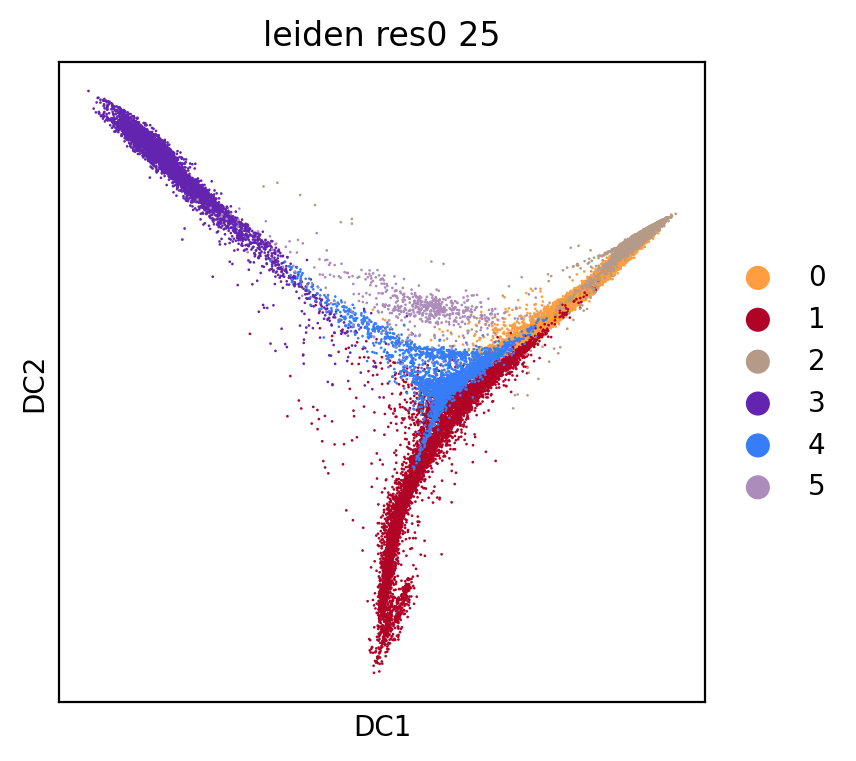

In [18]:
plt.rcParams['figure.figsize']=(4.15,4)
plt.rcParams['savefig.dpi'] = 1200

colors_clu = {
    "0": "#FF9E40", 
    "1": "#B00326",  
    "2": "#B59A88",
    "3": "#6325AF", 
    "4": "#367DF7",  
    "5": "#AB8CBA" 
}

adata.uns['leiden_res0_25_colors'] = [colors_clu[str(i)] for i in sorted(adata.obs['leiden_res0_25'].unique())]

sc.pl.scatter(
    adata,
    basis="diffmap",
    color=["leiden_res0_25"],
    components=[1, 2],
)


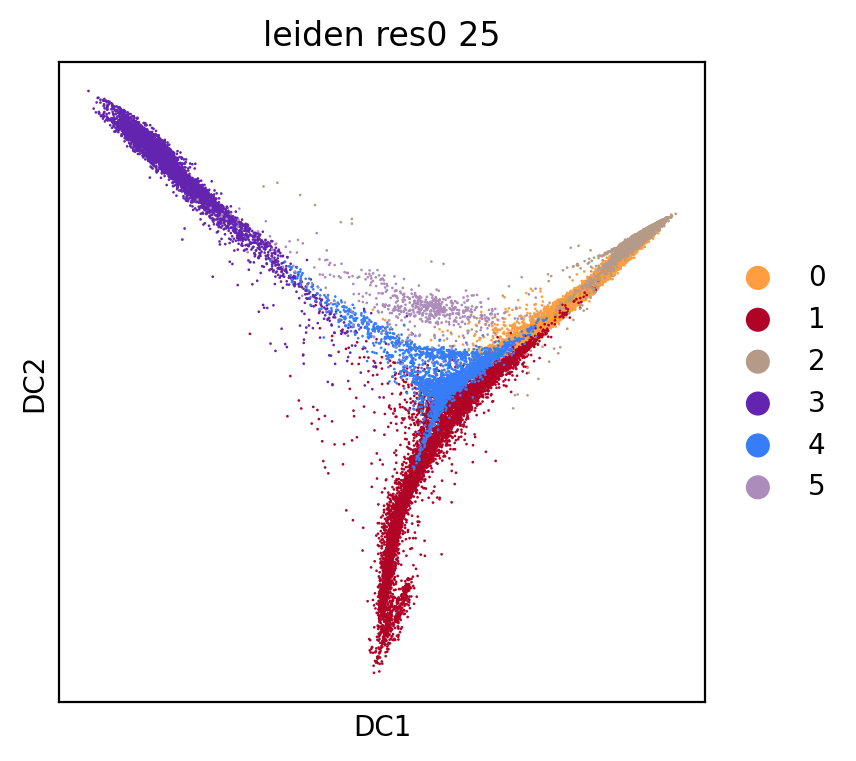

In [19]:
sc.pl.scatter(
    adata,
    basis="diffmap",
    color=["leiden_res0_25"],
    components=[1, 2],
    save="v2.pdf" 
)

### Add Jardine labeltransfer result

In [20]:
adata_jardine = sc.read_h5ad("/research/groups/sysgen/PROJECTS/sysgen_team/andrea_work/2023_Fischer_iPSC/revision_final/data/seurat_mapping_nonscaled_defaultHVG.h5ad")


In [23]:
adata_jardine.obs.head()

orig.ident  nCount_RNA  nFeature_RNA  sample  \
AAACCCAAGCGAACTG-1  SeuratProject     29339.0        5978.0  HW8_WT   
AAACCCACAAGAGTTA-1  SeuratProject     37476.0        7159.0  HW8_WT   
AAACCCACAAGCTCTA-1  SeuratProject     15174.0        3457.0  HW8_WT   
AAACCCAGTAGGAGGG-1  SeuratProject     16516.0        3411.0  HW8_WT   
AAACCCATCTGTCTCG-1  SeuratProject     10626.0        3212.0  HW8_WT   

                   etv6_runx1             barcode  n_counts  log_counts  \
AAACCCAAGCGAACTG-1         WT  AAACCCAAGCGAACTG-1   29339.0   10.286673   
AAACCCACAAGAGTTA-1         WT  AAACCCACAAGAGTTA-1   37476.0   10.531456   
AAACCCACAAGCTCTA-1         WT  AAACCCACAAGCTCTA-1   15174.0    9.627338   
AAACCCAGTAGGAGGG-1         WT  AAACCCAGTAGGAGGG-1   16516.0    9.712085   
AAACCCATCTGTCTCG-1         WT  AAACCCATCTGTCTCG-1   10626.0    9.271059   

                    n_genes   mt_frac  ... prediction.score.EoBasoMC  \
AAACCCAAGCGAACTG-1   5978.0  0.073997  ...                       0.0   
AAACCCACAAGAGTTA-1   7159.0  0.046803  ...                       0.0   
AAACCCACAAGCTCTA-1   3457.0  0.044484  ...                       0.0   
AAACCCAGTAGGAGGG-1   3411.0  0.079680  ...                       0.0   
AAACCCATCTGTCTCG-1   3212.0  0.003953  ...                       0.0   

                   prediction.score.MEP  prediction.score.MEP.MkP  \
AAACCCAAGCGAACTG-1             0.000000                  0.880690   
AAACCCACAAGAGTTA-1             0.000000                  1.000000   
AAACCCACAAGCTCTA-1             0.000000                  1.000000   
AAACCCAGTAGGAGGG-1             0.000000                  1.000000   
AAACCCATCTGTCTCG-1             0.168539                  0.492038   

                    prediction.score.DC.progenitor.II  \
AAACCCAAGCGAACTG-1                                0.0   
AAACCCACAAGAGTTA-1                                0.0   
AAACCCACAAGCTCTA-1                                0.0   
AAACCCAGTAGGAGGG-1                                0.0   
AAACCCATCTGTCTCG-1                                0.0   

                   prediction.score.HSC.MPP.IV  \
AAACCCAAGCGAACTG-1                         0.0   
AAACCCACAAGAGTTA-1                         0.0   
AAACCCACAAGCTCTA-1                         0.0   
AAACCCAGTAGGAGGG-1                         0.0   
AAACCCATCTGTCTCG-1                         0.0   

                   prediction.score.Late.EryP.II..Erythroblast.  \
AAACCCAAGCGAACTG-1                                          0.0   
AAACCCACAAGAGTTA-1                                          0.0   
AAACCCACAAGCTCTA-1                                          0.0   
AAACCCAGTAGGAGGG-1                                          0.0   
AAACCCATCTGTCTCG-1                                          0.0   

                    prediction.score.Late.EryP.I..Pro.erythroblast.  \
AAACCCAAGCGAACTG-1                                              0.0   
AAACCCACAAGAGTTA-1                                              0.0   
AAACCCACAAGCTCTA-1                                              0.0   
AAACCCAGTAGGAGGG-1                                              0.0   
AAACCCATCTGTCTCG-1                                              0.0   

                   prediction.score.EryP.III prediction.score.EryP.II  \
AAACCCAAGCGAACTG-1                       0.0                      0.0   
AAACCCACAAGAGTTA-1                       0.0                      0.0   
AAACCCACAAGCTCTA-1                       0.0                      0.0   
AAACCCAGTAGGAGGG-1                       0.0                      0.0   
AAACCCATCTGTCTCG-1                       0.0                      0.0   

                    prediction.score.max  
AAACCCAAGCGAACTG-1              0.880690  
AAACCCACAAGAGTTA-1              1.000000  
AAACCCACAAGCTCTA-1              1.000000  
AAACCCAGTAGGAGGG-1              1.000000  
AAACCCATCTGTCTCG-1              0.492038  

[5 rows x 45 columns]

In [24]:
print(adata_jardine.obs.columns)


Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'etv6_runx1',
       'barcode', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'celline',
       'leiden_res0_25', 'S_score', 'G2M_score', 'phase', 'phase_combined',
       'S/G2M_score_combined', 'Level 1', 'Level 2', 'Max-Rho',
       'Combined Correlation DiffScore', 'predicted.id',
       'prediction.score.Cycling.LyP', 'prediction.score.LyP.II..pro.B.',
       'prediction.score.LyP.I..CLP.', 'prediction.score.Early.LyP',
       'prediction.score.LyP.IV..pre.B.', 'prediction.score.MyP',
       'prediction.score.LyP.III..pro.B.', 'prediction.score.HSC.MPP.I',
       'prediction.score.HSC.MPP.III', 'prediction.score.EryP.IV',
       'prediction.score.EryP.I', 'prediction.score.HSC.MPP.II',
       'prediction.score.DC.progenitor.I', 'prediction.score.EoBasoMC',
       'prediction.score.MEP', 'prediction.score.MEP.MkP',
       'prediction.score.DC.progenitor.II', 'prediction.score.HSC.MPP.IV',
       'prediction.score.Late.E

In [25]:
adata.obs['cell_type_jardine'] = adata_jardine.obs['predicted.id']
adata.obs['prediction.score.max_jardine'] = adata_jardine.obs['prediction.score.max']

In [26]:
adata

AnnData object with n_obs × n_vars = 32358 × 33233
    obs: 'sample', 'etv6_runx1', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'celline', 'leiden_res0_25', 'S_score', 'G2M_score', 'phase', 'phase_combined', 'S/G2M_score_combined', 'Level 1', 'Level 2', 'Max-Rho', 'Combined Correlation DiffScore', 'cell_type_jardine', 'prediction.score.max_jardine'
    var: 'gene_id', '2', 'n_cells', 'highly_variable'
    uns: 'Level 1_colors', 'celline_colors', 'draw_graph', 'etv6_runx1_colors', 'leiden_res0_25', 'leiden_res0_25_colors', 'neighbors', 'pca', 'phase_combined_colors', 'sample_colors', 'umap', 'diffmap_evals', 'iroot'
    obsm: 'X_draw_graph_fa', 'X_orig_pca', 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    layers: 'log1p_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [30]:
keys_to_keep = ['leiden_res0_25_colors']
adata.uns = {key: adata.uns[key] for key in keys_to_keep}

In [31]:
print(adata.uns)

{'leiden_res0_25_colors': ['#FF9E40', '#B00326', '#B59A88', '#6325AF', '#367DF7', '#AB8CBA']}


In [32]:
adata

AnnData object with n_obs × n_vars = 32358 × 33233
    obs: 'sample', 'etv6_runx1', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'celline', 'leiden_res0_25', 'S_score', 'G2M_score', 'phase', 'phase_combined', 'S/G2M_score_combined', 'Level 1', 'Level 2', 'Max-Rho', 'Combined Correlation DiffScore', 'cell_type_jardine', 'prediction.score.max_jardine'
    var: 'gene_id', '2', 'n_cells', 'highly_variable'
    uns: 'leiden_res0_25_colors'
    obsm: 'X_draw_graph_fa', 'X_orig_pca', 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    layers: 'log1p_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [34]:
adata.var = adata.var.drop(columns=["2"])
adata.var.head()

gene_id  n_cells  highly_variable
gene_symbol                                           
MIR1302-2HG  ENSG00000243485       13            False
AL627309.1   ENSG00000238009      468            False
AL627309.3   ENSG00000239945       20            False
AL627309.2   ENSG00000239906        1            False
AL627309.5   ENSG00000241860     3012            False

In [36]:
adata.obs.head(3)

sample etv6_runx1             barcode  n_counts  \
barcode                                                               
AAACCCAAGCGAACTG-1  HW8_WT         WT  AAACCCAAGCGAACTG-1   29339.0   
AAACCCACAAGAGTTA-1  HW8_WT         WT  AAACCCACAAGAGTTA-1   37476.0   
AAACCCACAAGCTCTA-1  HW8_WT         WT  AAACCCACAAGCTCTA-1   15174.0   

                    log_counts  n_genes   mt_frac celline leiden_res0_25  \
barcode                                                                    
AAACCCAAGCGAACTG-1   10.286673     5978  0.073997     HW8              1   
AAACCCACAAGAGTTA-1   10.531456     7159  0.046803     HW8              1   
AAACCCACAAGCTCTA-1    9.627338     3457  0.044484     HW8              0   

                     S_score  G2M_score phase phase_combined  \
barcode                                                        
AAACCCAAGCGAACTG-1 -0.290829  -0.283942    G1             G1   
AAACCCACAAGAGTTA-1 -0.145809   0.874985   G2M          G2M/S   
AAACCCACAAGCTCTA-1 -0.217588  -0.123083    G1             G1   

                    S/G2M_score_combined Level 1         Level 2   Max-Rho  \
barcode                                                                      
AAACCCAAGCGAACTG-1             -0.287385     MEP       Erythroid  0.379255   
AAACCCACAAGAGTTA-1              0.364588     MKP  Megakaryocytic  0.493761   
AAACCCACAAGCTCTA-1             -0.170335     MKP  Megakaryocytic  0.532173   

                    Combined Correlation DiffScore cell_type_jardine  \
barcode                                                                
AAACCCAAGCGAACTG-1                        0.248309           MEP/MkP   
AAACCCACAAGAGTTA-1                        0.129070           MEP/MkP   
AAACCCACAAGCTCTA-1                        1.012451           MEP/MkP   

                    prediction.score.max_jardine  
barcode                                           
AAACCCAAGCGAACTG-1                       0.88069  
AAACCCACAAGAGTTA-1                       1.00000  
AAACCCACAAGCTCTA-1                       1.00000

In [37]:
adata.write ("/research/groups/sysgen/PROJECTS/sysgen_team/andrea_work/2023_Fischer_iPSC/revision_final/data/adata2_PCAharmony_leiden_LS_final.h5ad")
#final object